In [1]:
# License: BSD
# Author: Sasank Chilamkurthy

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from PIL import Image
from tempfile import TemporaryDirectory
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import random_split

In [2]:
data_dir = "C:/Users/user/OneDrive/Masaüstü/big2015_g/big2015_g/train"

# Define transformations for your images (adjust as needed)
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),  # Resize for EfficientNet-B3
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Create the ImageFolder dataset
dataset = datasets.ImageFolder(root=data_dir, transform=train_transforms)

# Define the validation set split ratio (e.g., 20% for validation)
val_split = 0.2

# Split the dataset into train and validation sets using random_split
train_size = int(len(dataset) * (1 - val_split))
val_size = len(dataset) - train_size
train_data, val_data = random_split(dataset, [train_size, val_size])

image_datasets = {
    'train': train_data,
    'val': val_data,
}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = dataset.classes

# ... rest of your transfer learning code using train_loader and val_loader
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
test_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.ToTensor(), 
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
test_data = datasets.ImageFolder("C:/Users/user/OneDrive/Masaüstü/big2015_g/big2015_g/test", transform=test_transform)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = 16, num_workers = 0)

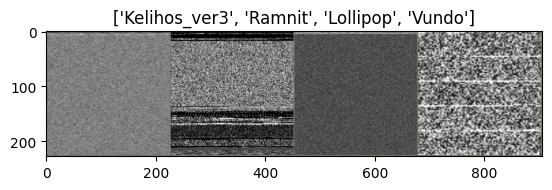

In [5]:
def imshow(inp, title=None):
    #Display image for Tensor
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [6]:
writer = SummaryWriter("C:/Users/user/experiment_efficientnetb7_sgd_001")

In [7]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            if phase == 'train':
                writer.add_scalar("Training Loss", epoch_loss, epoch)
                writer.add_scalar("Training Accuracy", epoch_acc, epoch)
            elif phase == 'val':
                writer.add_scalar("Validation Loss", epoch_loss, epoch)
                writer.add_scalar("Validation Accuracy", epoch_acc, epoch)
            

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')
    writer.close()
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [4]:
model_ft = models.efficientnet_b7(weights='IMAGENET1K_V1')
num_ftrs =  model_ft.classifier[1].in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model_ft.fc = nn.Linear(num_ftrs, 9)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.01, momentum=0.9) #0.01

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [9]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,num_epochs=120)

Epoch 0/119
----------
train Loss: 1.1228 Acc: 0.6850
val Loss: 0.8731 Acc: 0.6517

Epoch 1/119
----------
train Loss: 0.6757 Acc: 0.7864
val Loss: 0.4292 Acc: 0.8636

Epoch 2/119
----------
train Loss: 0.5566 Acc: 0.8241
val Loss: 0.4798 Acc: 0.8607

Epoch 3/119
----------
train Loss: 0.4957 Acc: 0.8464
val Loss: 0.3493 Acc: 0.8849

Epoch 4/119
----------
train Loss: 0.4282 Acc: 0.8633
val Loss: 0.4252 Acc: 0.8618

Epoch 5/119
----------
train Loss: 0.4057 Acc: 0.8702
val Loss: 0.3468 Acc: 0.8923

Epoch 6/119
----------
train Loss: 0.3684 Acc: 0.8838
val Loss: 0.2550 Acc: 0.9206

Epoch 7/119
----------
train Loss: 0.2845 Acc: 0.9084
val Loss: 0.2232 Acc: 0.9309

Epoch 8/119
----------
train Loss: 0.2562 Acc: 0.9175
val Loss: 0.2121 Acc: 0.9315

Epoch 9/119
----------
train Loss: 0.2495 Acc: 0.9156
val Loss: 0.2105 Acc: 0.9401

Epoch 10/119
----------
train Loss: 0.2333 Acc: 0.9247
val Loss: 0.2208 Acc: 0.9234

Epoch 11/119
----------
train Loss: 0.2278 Acc: 0.9220
val Loss: 0.1933 Acc

In [10]:
torch.save(model_ft.state_dict(), "C:/Users/user/Documents/experimentefficientnetb7sgd001.pt") #0.88 Acc

In [11]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

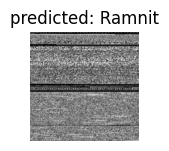

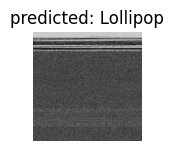

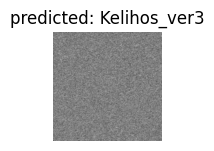

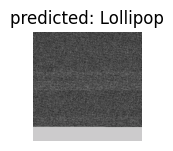

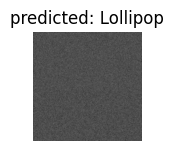

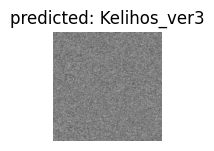

In [12]:
visualize_model(model_ft)

In [13]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        # calculate outputs by running images through the network
        outputs = model_ft(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the ferplus test images: {100 * correct // total} %')

Accuracy of the network on the ferplus test images: 93 %


Text(92.109375, 0.5, 'True labels')

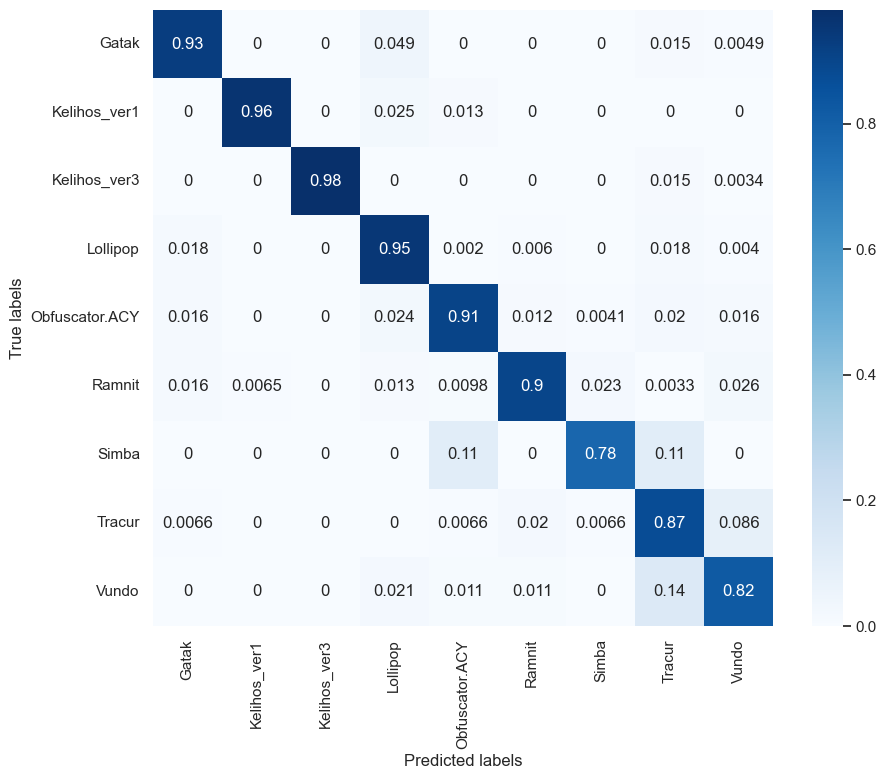

In [14]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
predicted_labels = []
true_labels = []
label_names = ['Gatak', 'Kelihos_ver1', 'Kelihos_ver3', 'Lollipop', 'Obfuscator.ACY', 'Ramnit', 'Simba', 'Tracur', 'Vundo']
model_ft.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model_ft(images)
        _,predicted = torch.max(outputs, 1)
        predicted_labels.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())
predicted_labels = np.array(predicted_labels)
true_labels = np.array(true_labels)
confusion = confusion_matrix(true_labels, predicted_labels)
normalized_matrix = confusion.astype('float') / confusion.sum(axis=1)[:, np.newaxis]
sns.set()
plt.figure(figsize=(10, 8))
sns.heatmap(normalized_matrix, annot=True, cmap="Blues", xticklabels=label_names, yticklabels=label_names)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")

In [5]:
#load model
model_ft.load_state_dict(torch.load("C:/Users/user/Documents/experiment_gri_tonlamali_B2IMG/experimentefficientnetb7sgd001.pt"))

<All keys matched successfully>

In [8]:
from sklearn.metrics import precision_score, recall_score, f1_score



# Set the model to evaluation mode
model_ft.eval()

# Initialize lists to hold true and predicted labels
true_labels = []
pred_labels = []

# Disable gradient calculation for evaluation
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = model_ft(images)
        _, preds = torch.max(outputs, 1)
        true_labels.extend(labels.cpu().numpy())
        pred_labels.extend(preds.cpu().numpy())

# Calculate precision, recall, and F1-score
precision = precision_score(true_labels, pred_labels, average='macro')
recall = recall_score(true_labels, pred_labels, average='macro')
f1 = f1_score(true_labels, pred_labels, average='macro')

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

Precision: 0.8815
Recall: 0.9163
F1 Score: 0.8963


Text(92.109375, 0.5, 'True labels')

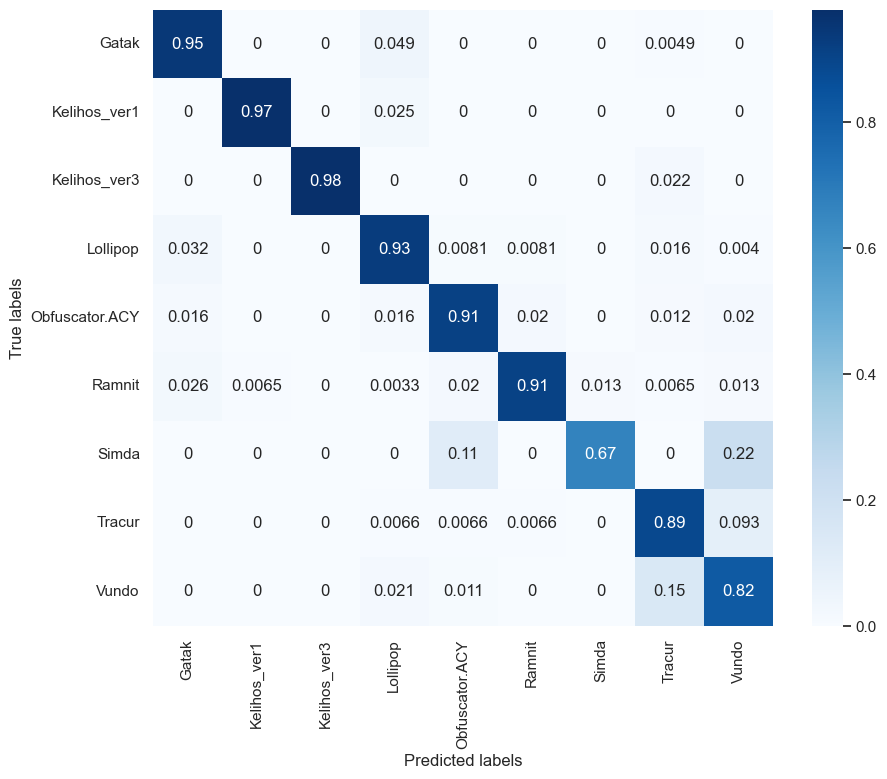

In [6]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
predicted_labels = []
true_labels = []
label_names = ['Gatak', 'Kelihos_ver1', 'Kelihos_ver3', 'Lollipop', 'Obfuscator.ACY', 'Ramnit', 'Simda', 'Tracur', 'Vundo']
model_ft.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model_ft(images)
        _,predicted = torch.max(outputs, 1)
        predicted_labels.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())
predicted_labels = np.array(predicted_labels)
true_labels = np.array(true_labels)
confusion = confusion_matrix(true_labels, predicted_labels)
normalized_matrix = confusion.astype('float') / confusion.sum(axis=1)[:, np.newaxis]
sns.set()
plt.figure(figsize=(10, 8))
sns.heatmap(normalized_matrix, annot=True, cmap="Blues", xticklabels=label_names, yticklabels=label_names)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")

In [13]:
# Evaluate the model on test data and record metrics
def evaluate_test_data_plot(model, criterion):
    model.eval()
    test_losses = []
    test_accuracies = []

    running_loss = 0.0
    running_corrects = 0
    num_batches = 0

    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        num_batches += 1

        batch_loss = loss.item()
        batch_acc = torch.sum(preds == labels.data).double() / inputs.size(0)

        test_losses.append(batch_loss)
        test_accuracies.append(batch_acc.cpu().numpy())

    test_loss = running_loss / len(test_data)
    test_acc = running_corrects.double() / len(test_data)

    print(f'Test Loss: {test_loss:.4f} Acc: {test_acc:.4f}')

    return test_losses, test_accuracies


# Plot metrics
def plot_metrics(test_loss, test_acc):
    num_epochs = len(test_acc)

    # Plot test metrics
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(range(num_epochs), test_loss, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Test Loss')

    plt.subplot(1, 2, 2)
    plt.plot(range(num_epochs), test_acc, label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Test Accuracy')

    plt.show()
    plt.tight_layout()
    plt.show()

Test Loss: 0.2033 Acc: 0.9361


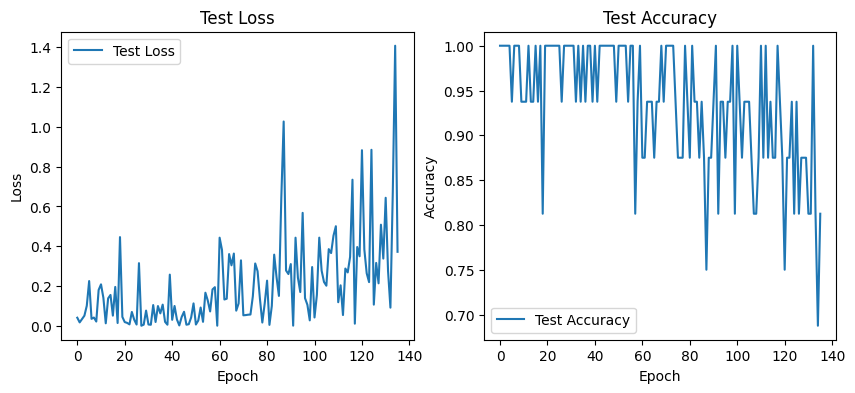

<Figure size 640x480 with 0 Axes>

In [14]:
test_loss, test_acc = evaluate_test_data_plot(model_ft, criterion)
plot_metrics(test_loss, test_acc)

In [ ]:
#test accuracy and text loss for entire dataset at the end of each epoch - bach 